# LowHighRegression from Level2 experiments


To install conda and binance packages to this notebook uncomment the code below

In [1]:
#%%capture
#%conda install -c plotly plotly=5.9.0
#%conda install pip
#%conda install twisted
# %pip install plotly==5.9.0
# %pip install twisted
# %pip install binance-connector==1.13.0
# %pip install pandas
#%pip install scikit-learn==1.5.1
#%pip install tensorflow==2.16.1
#%pip install keras==3.3.3
#%pip install keras==2.11.0
#%pip install scrapy==2.11.2
#%pip install itemloaders==1.2.0
# %pip install keras
# %pip install scikeras
# %pip install keras-tuner
# %pip install boto3
#%pip install python-dotenv
#%pip install prophet
%pip install ta

import os
import sys

import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
sys.path.append("pytrade2/pytrade2")
# Read .env variable with s3 access keys
#%load_ext dotenv
#%dotenv

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.2 -> 25.1.1
[notice] To update, run: python3.12 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## App parameters

In [2]:
# env file
#env_file='local.env'
env_file='local.env'
from dotenv import load_dotenv
dotenv_path = os.path.abspath(env_file) #travels up a level to find the .env
load_dotenv(dotenv_path)

ticker="BTC-USDT"
# Preprocess raw data
data_dir_root = "./data"
data_dir_raw = f"{data_dir_root}/raw"
data_dir_preproc = f"{data_dir_root}/preproc"

#history_days = 100
history_days=30
#history_days=720

# The best 07.09.2025 BTC-USDT, 30 days history, 7 test
# profit mean 106, median 182
# profit/drawdown 4.5
# profit trades: 16, loss trades: 19 per 7 days
# features_candles_periods = ["10min", "15min", "25min", "40min", "50min", "60min"]
# features_level2_periods = ["10min", "15min", "25min",  "40min", "50min", "60min"]
# target_period='15min'
# profit_loss_ratio = 3

features_candles_periods = ["10min", "15min", "25min", "40min", "50min", "60min"]
features_level2_periods = ["10min", "15min", "25min",  "40min", "50min", "60min"]
target_period='15min'
profit_loss_ratio = 3



#test_days = 15
test_days = 7

take_profit_min_coeff = 0.0012
stop_loss_max_coeff = 0.0048
# 0.001 = 60 for price=60K
#stop_loss_add_ratio = 0.0002
stop_loss_add_ratio = 0.001
#take_profit_max_coeff = 0.005
take_profit_max_coeff = 0.005 # 600
stop_loss_min_coeff = 0.00012
comission_pct = 0.012
price_precision = 2
is_trailing_stop = False
comission = 0.01 * comission_pct
#lgb_params = {'learning_rate':0.1, 'num_iterations': 100}
lgb_params = {'learning_rate':0.1, 'num_iterations': 100}


# lgb_params = {
#         #"n_estimators": 1000,
#         # "max_depth": 6,
#         # "min_samples_split": 10,
#         # "min_samples_leaf": 4,
#         # "bootstrap": True,
#         # "oob_score": False,
#         # "random_state": 888,
    
#     'learning_rate':0.1, 'num_iterations': 150}


experiment_name = 'LowHighRegression'
run_name =  f'LHR target: {target_period}, sharp: {profit_loss_ratio}, periods:{features_candles_periods},  history {history_days}, test {test_days}'
do_log_experiment = False
do_log_model = False
is_trade_ready = False



In [3]:
# Indicators' params for each candle period
features_params = {
    "5min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "10min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "20min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "30min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
    "40min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        },
}
# Default
#features_params = None
features_params = {
    "45min":
        {
            "cca": {"window": 20},
            "ichimoku": {"window1": 9, "window2": 26, "window3": 52},
            "adx": {"window": 14},
            "rsi": {"window": 14},
            "stoch": {"window": 14, "smooth_window": 3},
            "macd": {"slow": 26, "fast": 12}
        }
}

## Feature engineering
Read data from bot's history, resample to equal intervals, create X, y

### Read level2, bid/ask, candles data from history

### Preprocess data if configured

In [4]:
# import pathlib

# from features.level2.Level2Features import Level2Features
import numpy as np
from tools.PreprocTool import PreprocTool

preprocTool = PreprocTool(data_dir_root)
preprocTool.preprocess_last_raw_data(ticker, kind = "level2", days = history_days, transform_func = PreprocTool.level2_transform)
preprocTool.preprocess_last_raw_data(ticker, kind = "bid_ask", days = history_days)
preprocTool.preprocess_last_raw_data(ticker, kind = "candles", days = history_days, datetime_col = "close_time", agg = {"open_time" : "last", "close_time": "last", "open": "first", "high": "max", "low": "min", "close": "last", "vol": "sum"})


No new raw data appeared after 2025-05-10_BTC-USDT_level2.csv.zip
Preprocess 0 new level2 raw files
No new raw data appeared after 2025-05-10_BTC-USDT_bid_ask.csv.zip
Preprocess 0 new bid_ask raw files
No new raw data appeared after 2025-05-10_BTC-USDT_candles.csv.zip
Preprocess 0 new candles raw files


### Read preprocessed bid/ask, level2, candles

In [5]:
from tools.DataTool import DataTool
from strategy.persist.DataPersister import DataPersister
import os
import shutil
import numpy as np


def read_last_preproc_data(kind:str, days=1, datetime_col = "datetime"):
    """ Read last given days from preprocessed directory """
    
    source_dir = f"{data_dir_preproc}/{kind}"
    print(f"Read {ticker} {kind} data for {days} days from {source_dir}")

    file_paths = sorted(
        [f"{source_dir}/{f}" for f in os.listdir(source_dir) if f.endswith(".csv")])[-days:]
    
    df = pd.concat([pd.read_csv(f, parse_dates=True) for f in file_paths])
    df = clean_columns(df, datetime_col)
    return df
    
def clean_columns(df: pd.DataFrame, datetime_col: str = "datetime"):
    """ After level2, bidask or candles df has been read, set datetime index, clean columns which are not needed"""
    remove_cols = [f"{datetime_col}.1","ticker", "symbol"]
    for remove_col in remove_cols:
        if remove_col in df.columns:
            del df[remove_col]
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    df.set_index(datetime_col, drop = False, inplace = True)
    return df


In [6]:
df_bid_ask = preprocTool.read_last_preproc_data(ticker, "bid_ask", days = history_days)
df_bid_ask.tail()

Read BTC-USDT bid_ask data for 30 days from ./data/preproc/bid_ask


datetime            bid      bid_vol            ask      ask_vol
datetime                                                                                       
2025-05-10 07:20:00 2025-05-10 07:20:00  103776.316617  3712.231744  103776.598659  1680.663189
2025-05-10 07:21:00 2025-05-10 07:21:00  103823.912613  4821.997426  103824.111068  4308.758044
2025-05-10 07:22:00 2025-05-10 07:22:00  103809.880088   749.428884  103810.186105  7065.660832
2025-05-10 07:23:00 2025-05-10 07:23:00  103771.281970  1393.230328  103771.733142  5791.725378
2025-05-10 07:24:00 2025-05-10 07:24:00  103719.659230    45.661316  103719.920225  6276.621188

In [7]:
df_candles_1min = preprocTool.read_last_preproc_data(ticker, "candles", datetime_col = "close_time", days = history_days)
df_candles_1min.tail()

Read BTC-USDT candles data for 30 days from ./data/preproc/candles


close_time            open_time      open      high       low     close     vol
close_time                                                                                                  
2025-05-10 07:19:00 2025-05-10 07:19:00  2025-05-10 07:18:00  103747.7  103791.5  103747.7  103791.5   96008
2025-05-10 07:20:00 2025-05-10 07:20:00  2025-05-10 07:19:00  103791.5  103827.0  103791.5  103826.9   78306
2025-05-10 07:21:00 2025-05-10 07:21:00  2025-05-10 07:20:00  103826.9  103827.0  103785.2  103785.2   41994
2025-05-10 07:22:00 2025-05-10 07:22:00  2025-05-10 07:21:00  103785.2  103800.7  103730.4  103730.4  130230
2025-05-10 07:23:00 2025-05-10 07:23:00  2025-05-10 07:22:00  103730.4  103730.4  103709.3  103709.3     500

In [8]:
df_level2 = preprocTool.read_last_preproc_data(ticker, "level2", days = history_days)
df_level2.tail()

Read BTC-USDT level2 data for 30 days from ./data/preproc/level2


datetime     l2_bid_max     l2_bid_vol  l2_bid_expect     l2_ask_min     l2_ask_vol  l2_ask_expect  l2_bid_ask_expect  l2_bid_ask_vol
datetime                                                                                                                                                            
2025-05-10 07:20:00 2025-05-10 07:20:00  103769.500000  119932.535000  103686.075984  103779.500000  117289.751667  103866.075660      103774.996498   237222.286667
2025-05-10 07:21:00 2025-05-10 07:21:00  103817.533333  129517.513333  103736.023690  103827.533333  125044.775000  103922.626542      103827.826256   254562.288333
2025-05-10 07:22:00 2025-05-10 07:22:00  103805.216667  114487.631667  103712.088403  103815.216667  133914.603333  103896.245813      103811.436398   248402.235000
2025-05-10 07:23:00 2025-05-10 07:23:00  103774.414716  114912.573579  103685.459887  103784.431438  124806.287625  103862.909179      103778.118094   239718.861204
2025-05-10 07:24:00 2025-05-10 07:24:00  103720.468750   71999.125000  103624.190994  103730.468750  139537.218750  103806.440855      103744.428311   211536.343750

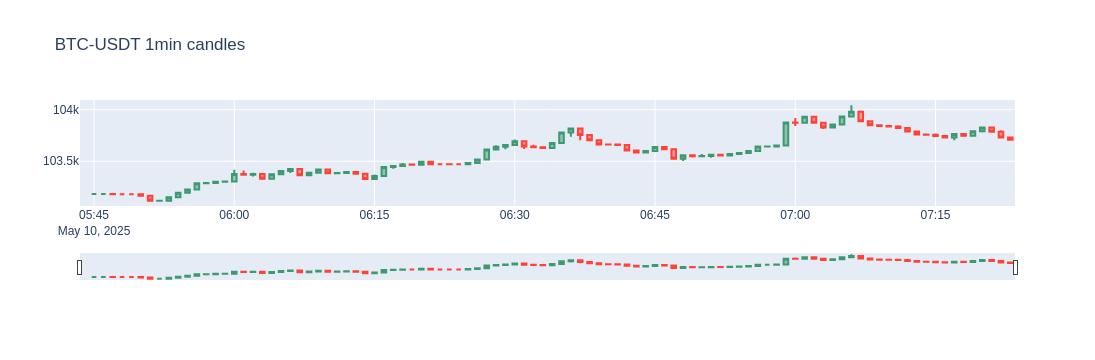

In [9]:
from tools.PlotTool import PlotTool
df_candles_1min["ticker"] = ticker
PlotTool.plot_candles(df_candles_1min.tail(100), '1min')

### Build features and targets

#### Prepare Level 2 features

In [10]:
from ta import trend, momentum
from features.MultiIndiFeatures import MultiIndiFeatures

def level2_ichimoku_of(df_level2: pd.DataFrame, period: str = '', window1=9, window2=26, window3=52):
    df = pd.DataFrame()
    ichimoku = trend.IchimokuIndicator(df_level2['l2_ask_expect'], df_level2['l2_bid_expect'],
                                       window1=window1, window2=window2, window3=window3, fillna=False)
    # df[f'l2_ichimoku_base_line_{period}_diff'] = ichimoku.ichimoku_base_line().diff()
    # df[f'l2_ichimoku_conversion_line_{period}_diff'] = ichimoku.ichimoku_conversion_line().diff()
    # df[f'l2_ichimoku_a_{period}_diff'] = ichimoku.ichimoku_a().diff()
    # df[f'l2_ichimoku_b_{period}_diff'] = ichimoku.ichimoku_b().diff()
    df[f'l2_ichimoku_base_line_{period}'] = ichimoku.ichimoku_base_line()
    df[f'l2_ichimoku_conversion_line_{period}'] = ichimoku.ichimoku_conversion_line()
    df[f'l2_ichimoku_a_{period}'] = ichimoku.ichimoku_a()
    df[f'l2_ichimoku_b_{period}'] = ichimoku.ichimoku_b()
    return df
    
def level2_indicators_of(df_level2, period, params: dict = None):
    """ Single period indicators"""

    if not params:
        params = MultiIndiFeatures.default_params


    resampled = df_level2.resample(period, closed="right").agg("mean")    
    resampled["l2_price"] = (resampled["l2_bid_max"] + resampled["l2_ask_min"]) / 2
    
    df = level2_ichimoku_of(resampled,
                                       period,
                                       params["ichimoku"]["window1"],
                                       params["ichimoku"]["window2"],
                                       params["ichimoku"]["window3"], )
    df[f'l2_cci_{period}_diff'] = trend.cci(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                         window=params["cca"]["window"], fillna=False).diff()
    df[f'l2_adx_{period}_diff'] = trend.adx(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                         window=params["adx"]["window"], fillna=False).diff()
    df[f'l2_rsi_{period}_diff'] = momentum.rsi(resampled['l2_price'], window=params["rsi"]["window"], fillna=False).diff()
    df[f'l2_stoch_{period}_diff'] = momentum.stoch(resampled['l2_ask_expect'], resampled['l2_bid_expect'], resampled['l2_price'],
                                                window=params["stoch"]["window"],
                                                smooth_window=params["stoch"]["smooth_window"], fillna=False).diff()
    df[f'l2_macd_{period}_diff'] = trend.macd(resampled['l2_price'], window_slow=params["macd"]["slow"],
                                           window_fast=params["macd"]["fast"], fillna=False).diff()

    #df = df.dropna()
    return df

def level2_features_of(df_level2, periods):
    #df = df_level2.copy()
    #del df["datetime"]

    level2_features = []
    for period in periods:
        period_indicators = level2_indicators_of(df_level2, period)
        level2_features.append(period_indicators)
    level2_features = pd.concat(level2_features).sort_index().ffill()
    
    level2_features = level2_features.dropna()
    #features = features.diff().add_suffix("_diff")
    return level2_features

# level2_features = level2_features_of(df_level2, features_level2_periods)
# level2_features.tail()

In [11]:
level2_features = level2_features_of(df_level2, features_level2_periods)
level2_features.tail()

l2_ichimoku_base_line_10min  l2_ichimoku_conversion_line_10min  l2_ichimoku_a_10min  l2_ichimoku_b_10min  l2_cci_10min_diff  l2_adx_10min_diff  l2_rsi_10min_diff  l2_stoch_10min_diff  l2_macd_10min_diff  l2_ichimoku_base_line_15min  l2_ichimoku_conversion_line_15min  l2_ichimoku_a_15min  l2_ichimoku_b_15min  l2_cci_15min_diff  l2_adx_15min_diff  l2_rsi_15min_diff  l2_stoch_15min_diff  l2_macd_15min_diff  l2_ichimoku_base_line_25min  l2_ichimoku_conversion_line_25min  l2_ichimoku_a_25min  l2_ichimoku_b_25min  l2_cci_25min_diff  l2_adx_25min_diff  l2_rsi_25min_diff  l2_stoch_25min_diff  l2_macd_25min_diff  l2_ichimoku_base_line_40min  l2_ichimoku_conversion_line_40min  l2_ichimoku_a_40min  l2_ichimoku_b_40min  l2_cci_40min_diff  l2_adx_40min_diff  l2_rsi_40min_diff  l2_stoch_40min_diff  l2_macd_40min_diff  l2_ichimoku_base_line_50min  l2_ichimoku_conversion_line_50min  l2_ichimoku_a_50min  l2_ichimoku_b_50min  l2_cci_50min_diff  l2_adx_50min_diff  l2_rsi_50min_diff  l2_stoch_50min_diff  l2_macd_50min_diff  l2_ichimoku_base_line_60min  l2_ichimoku_conversion_line_60min  l2_ichimoku_a_60min  l2_ichimoku_b_60min  l2_cci_60min_diff  l2_adx_60min_diff  l2_rsi_60min_diff  l2_stoch_60min_diff  l2_macd_60min_diff
datetime                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   
2025-05-10 07:05:00                103440.365176                      103544.442240        103492.403708        103339.652077          54.551542           2.591093           7.145147            13.394989           28.159104                103356.339937                      103500.066341        103428.203139        103329.382367          33.338237           2.733297           6.111399            11.194759           32.663832                  103311.1185                      103452.663746        103381.891123        103225.272987          -6.732627           2.529103           3.095838             1.536151           35.552304                103178.823833                      103351.406582        103265.115208        103039.190132          27.186420           1.677396           3.974487             2.640476           38.654229                103196.525926                      103331.021045        103263.773486        101506.411089          58.625862           1.357547           4.681611             3.940553            35.51242                103257.803167                      103349.609716        103303.706442        101320.080137           31.13939           1.026736           3.767814             2.886423           34.223728
2025-05-10 07:10:00                103440.365176                      103559.775206        103500.070191        103339.652077         -63.325242           1.061874          -8.946705           -12.370548           10.854664                103356.339937                      103500.066341  

### All features

In [12]:
sys.path.append("pytrade2/pytrade2")
from pytrade2.pytrade2.features.CandlesFeatures import CandlesFeatures
from pytrade2.pytrade2.features.MultiIndiFeatures import MultiIndiFeatures
from pytrade2.pytrade2.features.LowHighTargets import LowHighTargets
 
# Candles by periods dictionary
candles_by_period = DataTool.candles_by_periods_of(df_candles_1min, features_candles_periods)
#print('Candles counts: %s' % {period: len(df) for period, df in candles_by_period.items()})

# Features
candles_features = MultiIndiFeatures.multi_indi_features(candles_by_period, features_params)
print(candles_features.info())

#level2_features = level2_features_of(df_level2)
features = pd.merge_asof(candles_features, level2_features, left_index = True, right_index=True)


if target_period not in candles_by_period:
    candles_for_targets = DataTool.candles_by_periods_of(df_candles_1min, [target_period])[target_period]
else:
    candles_for_targets = candles_by_period[target_period]

targets = LowHighTargets.fut_lohi(candles_for_targets, target_period)
features = features.dropna()
targets = targets.dropna()
features = features[features.index.isin(targets.index)]
targets = targets[targets.index.isin(features.index)]

features.tail()
#targets.tail(100)
#targets.info()
#targets[targets.isna()].tail()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5977 entries, 2025-04-12 00:00:00 to 2025-05-10 07:20:00
Data columns (total 56 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   time_hour                            5977 non-null   float64
 1   time_minute                          5977 non-null   float64
 2   ichimoku_base_line_10min_diff        5977 non-null   float64
 3   ichimoku_conversion_line_10min_diff  5977 non-null   float64
 4   ichimoku_a_10min_diff                5977 non-null   float64
 5   ichimoku_b_10min_diff                5977 non-null   float64
 6   cci_10min_diff                       5977 non-null   float64
 7   adx_10min_diff                       5977 non-null   float64
 8   rsi_10min_diff                       5977 non-null   float64
 9   stoch_10min_diff                     5977 non-null   float64
 10  macd_10min_diff                      5977 non-null   float64

time_hour  time_minute  ichimoku_base_line_10min_diff  ichimoku_conversion_line_10min_diff  ichimoku_a_10min_diff  ichimoku_b_10min_diff  cci_10min_diff  adx_10min_diff  rsi_10min_diff  stoch_10min_diff  macd_10min_diff  ichimoku_base_line_15min_diff  ichimoku_conversion_line_15min_diff  ichimoku_a_15min_diff  ichimoku_b_15min_diff  cci_15min_diff  adx_15min_diff  rsi_15min_diff  stoch_15min_diff  macd_15min_diff  ichimoku_base_line_25min_diff  ichimoku_conversion_line_25min_diff  ichimoku_a_25min_diff  ichimoku_b_25min_diff  cci_25min_diff  adx_25min_diff  rsi_25min_diff  stoch_25min_diff  macd_25min_diff  ichimoku_base_line_40min_diff  ichimoku_conversion_line_40min_diff  ichimoku_a_40min_diff  ichimoku_b_40min_diff  cci_40min_diff  adx_40min_diff  rsi_40min_diff  stoch_40min_diff  macd_40min_diff  ichimoku_base_line_50min_diff  ichimoku_conversion_line_50min_diff  ichimoku_a_50min_diff  ichimoku_b_50min_diff  cci_50min_diff  adx_50min_diff  rsi_50min_diff  stoch_50min_diff  macd_50min_diff  ichimoku_base_line_60min_diff  ichimoku_conversion_line_60min_diff  ichimoku_a_60min_diff  ichimoku_b_60min_diff  cci_60min_diff  adx_60min_diff  rsi_60min_diff  stoch_60min_diff  macd_60min_diff  l2_ichimoku_base_line_10min  l2_ichimoku_conversion_line_10min  l2_ichimoku_a_10min  l2_ichimoku_b_10min  l2_cci_10min_diff  l2_adx_10min_diff  l2_rsi_10min_diff  l2_stoch_10min_diff  l2_macd_10min_diff  l2_ichimoku_base_line_15min  l2_ichimoku_conversion_line_15min  l2_ichimoku_a_15min  l2_ichimoku_b_15min  l2_cci_15min_diff  l2_adx_15min_diff  l2_rsi_15min_diff  l2_stoch_15min_diff  l2_macd_15min_diff  l2_ichimoku_base_line_25min  l2_ichimoku_conversion_line_25min  l2_ichimoku_a_25min  l2_ichimoku_b_25min  l2_cci_25min_diff  l2_adx_25min_diff  l2_rsi_25min_diff  l2_stoch_25min_diff  l2_macd_25min_diff  l2_ichimoku_base_line_40min  l2_ichimoku_conversion_line_40min  l2_ichimoku_a_40min  l2_ichimoku_b_40min  l2_cci_40min_diff  l2_adx_40min_diff  l2_rsi_40min_diff  l2_stoch_40min_diff  l2_macd_40min_diff  l2_ichimoku_base_line_50min  l2_ichimoku_conversion_line_50min  l2_ichimoku_a_50min  l2_ichimoku_b_50min  l2_cci_50min_diff  l2_adx_50min_diff  l2_rsi_50min_diff  l2_stoch_50min_diff  l2_macd_50min_diff  l2_ichimoku_base_line_60min  l2_ichimoku_conversion_line_60min  l2_ichimoku_a_60min  l2_ichimoku_b_60min  l2_cci_60min_diff  l2_adx_60min_diff  l2_rsi_60min_diff  l2_stoch_60min_diff  l2_macd_60min_diff
close_time                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

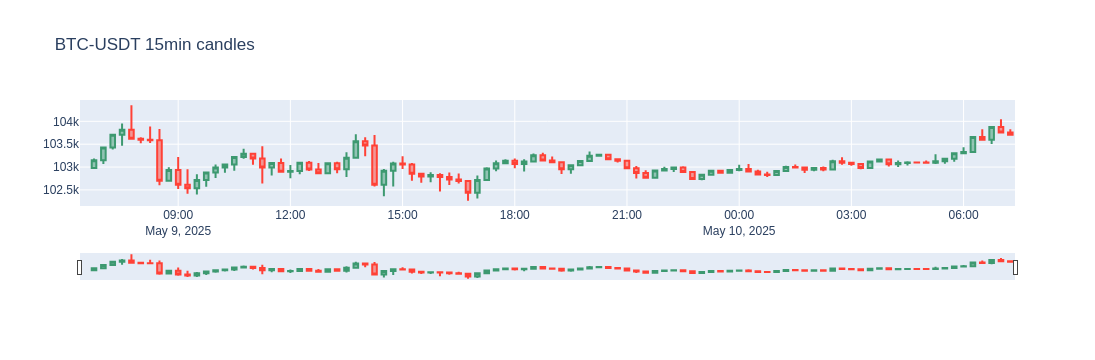

In [13]:
#PlotTool.plot_candles(candles_by_period['10min'].tail(100), target_period)
PlotTool.plot_candles(candles_for_targets.tail(100), target_period, ticker)
#candles_by_period[target_period].tail()


### Train test split

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, MaxAbsScaler

def create_pipe(x, y) -> (Pipeline, Pipeline):
    """ Create feature and target pipelines to use for transform and inverse transform """

    time_cols = [col for col in x.columns if col.startswith("time")]
    float_cols = list(set(x.columns) - set(time_cols))
    x_pipe = Pipeline(
        [("xscaler", ColumnTransformer([("xrs", StandardScaler(), float_cols)], remainder="passthrough")),
         ("xmms", MaxAbsScaler())])
    x_pipe.fit(x)

    y_pipe = Pipeline(
        [("yrs", StandardScaler()),
         ("ymms", MaxAbsScaler())])
    y_pipe.fit(y)
    return x_pipe, y_pipe


In [15]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
import matplotlib.pyplot as plt

def train_test_split(x, y, test_days=14):
    """ In addition to train_test_split, create pipeline for reverse transform in future"""
    #test_index = int(len(x)*(1-test_size))
    print(x.info())
    test_index = max(x.index) - pd.Timedelta(days=test_days)
    is_test = (x.index >= test_index)
    is_train = (x.index < test_index)
    
    x_train, y_train, x_test, y_test = x[is_train], y[is_train], \
        x[is_test], y[is_test]
    
    #test_index = int(len(x)*(1-test_size))

    # Split df to train/test
    # x_train, y_train, x_test, y_test = x.iloc[:test_index], y.iloc[:test_index], \
    #     x.iloc[test_index:], y.iloc[test_index:]

    # Create pipeline to transform/reverse transform
    x_pipe, y_pipe = create_pipe(x_train, y_train)
    return x_pipe, y_pipe, x_train, y_train, x_test, y_test


x_pipe, y_pipe, x_train, y_train, x_test, y_test = train_test_split(features, targets, test_days=test_days)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2713 entries, 2025-04-12 01:00:00 to 2025-05-10 07:00:00
Columns: 110 entries, time_hour to l2_macd_60min_diff
dtypes: float64(110)
memory usage: 2.3 MB
None


## Model creation and training

### Create model

In [16]:
import lightgbm as lgb
from sklearn.multioutput import MultiOutputRegressor
from keras import Sequential, Input
from keras.layers import Dense, Dropout
from sklearn.linear_model import LinearRegression

model_name='MultiOutputRegressorLgb'
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
mlflow_client = MlflowClient()

def create_model_linreg():
    
    model = LinearRegression()
    model = MultiOutputRegressor(model)
    print(f'Created new model {model}')
    return model

def create_model_keras(X_size, y_size):
    model = Sequential()
    model.add(Input(shape=(X_size,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(y_size, activation='linear'))
    model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mean_squared_error'])

    # Load weights
    #self.model_persister.load_last_model(model)
    model.summary()
    return model


def create_model_lgb(lgb_params):
    """ MultiOutputRegressor with lgb model. """
    lgb_model =  lgb.LGBMRegressor(**lgb_params)
    model = MultiOutputRegressor(lgb_model)
    print(f'Created new model {model}')
    return model

def ensure_model(model_name):
    versions = mlflow_client.search_model_versions(f"name='{model_name}'")

    if versions:
        version = versions[-1]
        model = mlflow.sklearn.load_model(versions[-1].source)
        model_url = f'models:/{model_name}/{version.version}'
    else:
        model = create_model()
        model_url = None
    return model, model_url

#model, model_url = ensure_model(model_name)
#print(model_url)
#model = create_model(len(features.columns), len(targets.columns))
model = create_model_lgb(lgb_params)


2025-05-10 11:01:59.255781: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-10 11:02:00.042656: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Created new model MultiOutputRegressor(estimator=LGBMRegressor(num_iterations=100))


### Fit, predict

In [17]:
model.fit(x_pipe.transform(x_train), y_pipe.transform(y_train), feature_name = x_train.columns.tolist())
# Predict and inverse transform to dataframe
y_pred = model.predict(x_pipe.transform(x_test))
y_pred = y_pipe.inverse_transform(y_pred)
y_pred = pd.DataFrame(y_pred, columns = y_test.columns, index = y_test.index)
y_pred.tail()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26663
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 110
[LightGBM] [Info] Start training from score -0.000000


/home/dima/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/home/dima/.local/lib/python3.12/site-packages/lightgbm/engine.py:172: UserWarning:

Found `num_iterations` in params. Will use it instead of argument



[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001530 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26663
[LightGBM] [Info] Number of data points in the train set: 2040, number of used features: 110
[LightGBM] [Info] Start training from score -0.000000


fut_low_diff  fut_high_diff
close_time                                      
2025-05-10 06:00:00   -101.153990     491.609983
2025-05-10 06:15:00   -254.058927     140.059413
2025-05-10 06:30:00    -21.111468     379.424526
2025-05-10 06:45:00   -282.231821     127.065183
2025-05-10 07:00:00   -145.376103     242.659925

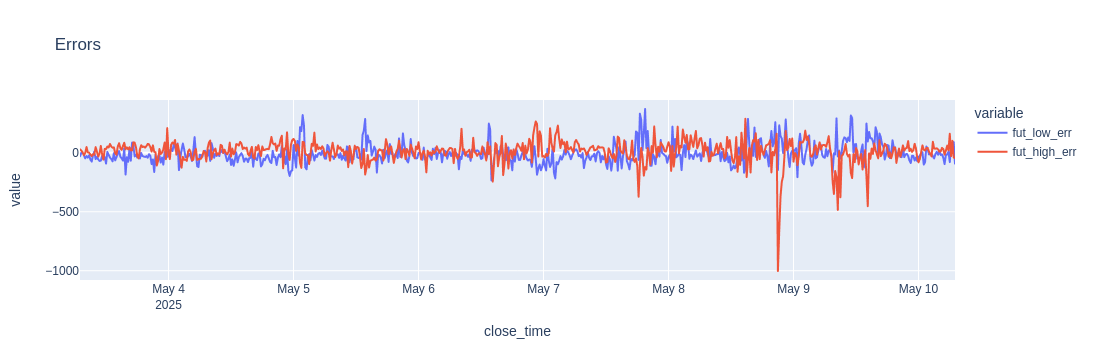

In [18]:
import plotly as py
import plotly.express as px
from plotly import graph_objects as go
# Remove plotly warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plot_y_pred_err(y_test, y_pred):
    err = pd.DataFrame()
    err['fut_low_err'] = y_pred['fut_low_diff'] - y_test['fut_low_diff']
    err['fut_high_err'] = y_pred['fut_high_diff'] - y_test['fut_high_diff']
    px.line(err, title='Errors').show()

plot_y_pred_err(y_test, y_pred)


# Evaluate the model

### Trading emulation

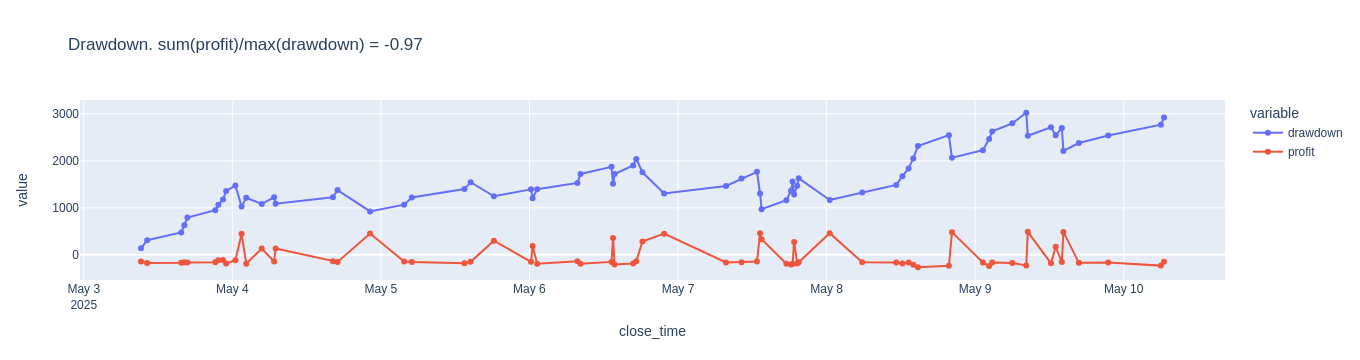

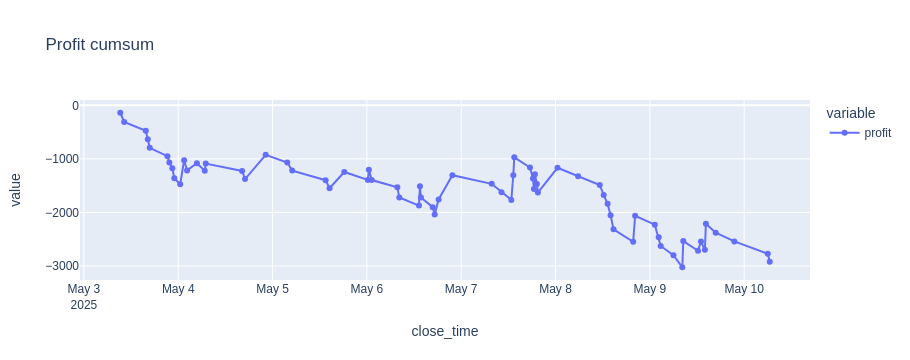

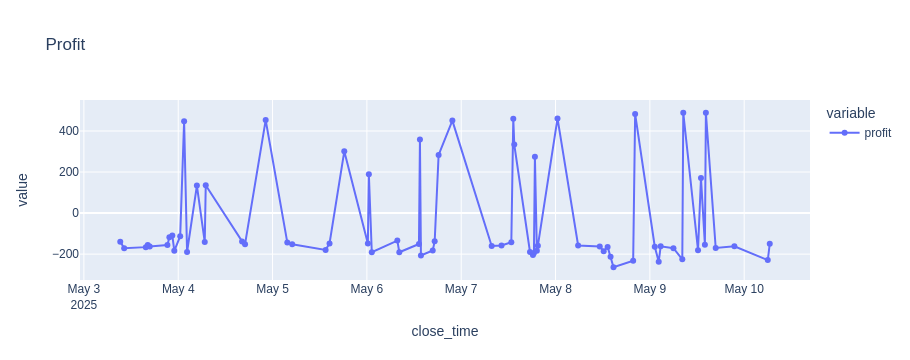

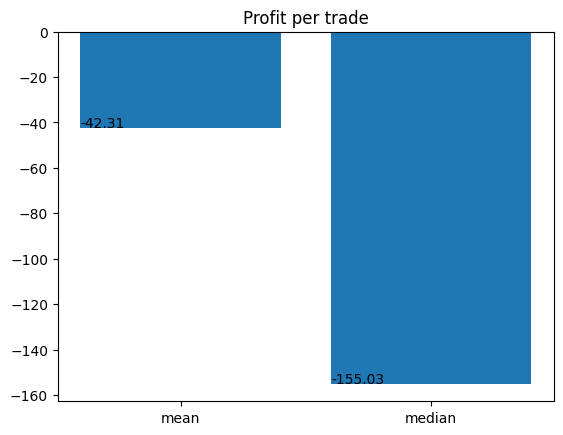

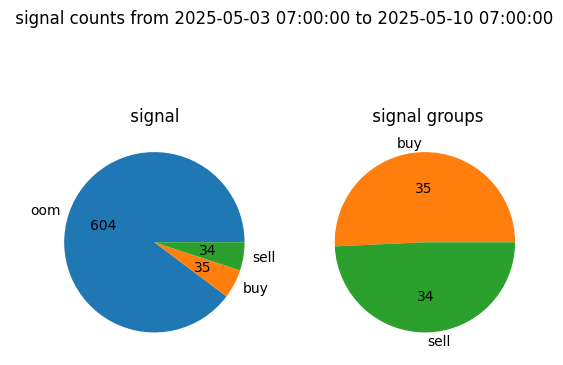

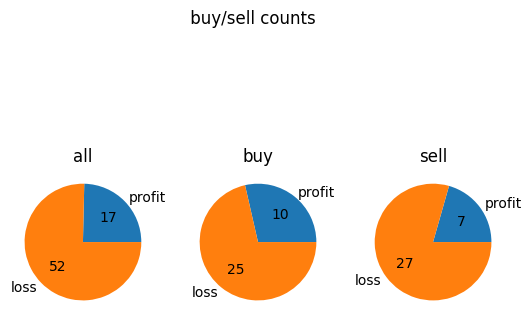

In [19]:
from pytrade2.pytrade2.strategy.signal.SignalByFutLowHigh import SignalByFutLowHigh
import seaborn as sns


def calc_signal_ext(candles_target, y_test, y_pred):
    """ Using predicted values, create dataframe with signal, stoploss, takeprofit """
    # Combine test with pred
    fut_df = pd.DataFrame(index = y_pred.index)
    fut_df['close'] = candles_target['close']
    fut_df['fut_low'] = candles_target['close'] + y_test['fut_low_diff']
    fut_df['fut_high'] = candles_target['close'] + y_test['fut_high_diff']
    fut_df['fut_low_pred'] = candles_target['close'] + y_pred['fut_low_diff']
    fut_df['fut_high_pred'] = candles_target['close'] + y_pred['fut_high_diff']

    # Signal calculator from pytrade2
    signal_calc = SignalByFutLowHigh(profit_loss_ratio=profit_loss_ratio,
                                stop_loss_min_coeff=stop_loss_min_coeff,
                                stop_loss_max_coeff=stop_loss_max_coeff,
                                stop_loss_add_ratio = stop_loss_add_ratio,
                                take_profit_min_coeff=take_profit_min_coeff,
                                take_profit_max_coeff=take_profit_max_coeff,
                                comission_pct=comission_pct,
                                price_presision=price_precision)
    
    # Create df: signal, stoploss, take profit
    signal_df = fut_df[['close', 'fut_low_pred', 'fut_high_pred']]\
            .apply(lambda row: signal_calc.calc_signal(row[0], row[1], row[2]), axis=1, result_type='expand')
    signal_df.columns = ['signal', 'sl', 'tp']    
    signal_df = pd.concat([signal_df, fut_df], axis=1)
    signal_df = with_profit(signal_df)
    signal_df = with_drawdown(signal_df)    
    return pd.concat([signal_df, fut_df], axis=1)
    
def with_profit(signal):
    """ Metric: profit it trade by predicted values """

    # Buy and price keeps above stop loss and goes over tp
    is_buy_profit = (signal['signal'] == 1) & (signal['fut_low'] > signal['sl']) & (signal['fut_high'] >= signal['tp'])
    is_buy_loss = (signal['signal'] == 1) & (~is_buy_profit)
    
    # Sell and price keeps below stop loss and goes below tp
    is_sell_profit = (signal['signal'] == -1) & (signal['fut_high'] < signal['sl']) & (signal['fut_low'] <= signal['tp'])
    is_sell_loss = (signal['signal'] == -1) & (~is_sell_profit)

    #profit = pd.DataFrame(index = signal.index)
    signal['profit'] = 0

    # Buy profit or loss
    signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # Sell profit or loss
    signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)

    # # Buy profit or loss
    # signal.loc[is_buy_profit, 'profit'] = signal['tp'] - signal['close'] - (signal['tp']*comission) - (signal['close']*comission)
    # signal.loc[is_buy_loss, 'profit'] = signal['sl'] - signal['close'] - (signal['sl']*comission) - (signal['close']*comission)

    # # Sell profit or loss
    # signal.loc[is_sell_profit, 'profit'] = signal['close'] - signal['tp'] - (signal['close']*comission) - (signal['tp']*comission)
    # signal.loc[is_sell_loss, 'profit'] = signal['close'] - signal['sl'] - (signal['close']*comission) - (signal['sl']*comission)
    
    return signal

def with_drawdown(df):
    # todo: remove -10
    #profits = df.loc[df['profit'] != 0, 'profit'][:-10]
    profits = df['profit']
    max_drawdown = 0
    cur_drawdown = 0
    drawdowns = []
        
    for profit in profits.values:
        if profit < 0:
            # Loss - increase drawdown
            cur_drawdown -= profit # increase drawdown
        else:
            # We have profit! Decrease drowdown, or if profit covered previous drawdown, set drawdown to 0.
            cur_drawdown = max(0, cur_drawdown - profit)
        max_drawdown = max(max_drawdown, cur_drawdown)
        drawdowns.append(cur_drawdown)

    df['drawdown'] = drawdowns
    return df

def plot_drawdown(signal_ext):
    drawdown = max(signal_ext['drawdown'])
    profit = sum(signal_ext['profit'])
    ratio = round(profit/drawdown, 2) if drawdown > 0 else 'infinity'
    title = f'Drawdown. sum(profit)/max(drawdown) = {ratio}'
    px.line(signal_ext.loc[signal_ext['signal']!=0, ['drawdown', 'profit']], title = title).update_traces(mode='lines+markers').show()

def barplot_profit(signal_ext):
    profit_df = signal_ext.loc[signal_ext['profit']!=0, 'profit']
    mean = profit_df.mean()
    median = profit_df.median()
    
    bars = plt.bar(x=["mean", "median"], height=[mean, median])
    for bar in bars:
        yval = round(bar.get_height(), 2)
        plt.text(bar.get_x(), yval + .005, yval)
    
    plt.title('Profit per trade');
    plt.show()

    #sns.barplot(x=["mean", "median1"], y=[mean, median]);
    

signal_ext = calc_signal_ext(candles_for_targets, y_test, y_pred)

# Drawdown plot
plot_drawdown(signal_ext)

# Profit cumsumplot
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'].cumsum(), title = 'Profit cumsum').update_traces(mode='lines+markers').show()
px.line(signal_ext.loc[signal_ext['signal']!=0, 'profit'], title = f'Profit').update_traces(mode='lines+markers').show()
barplot_profit(signal_ext)

# Pie plots
PlotTool.plot_signal_counts(signal_ext)
PlotTool.plot_buy_sell(signal_ext)

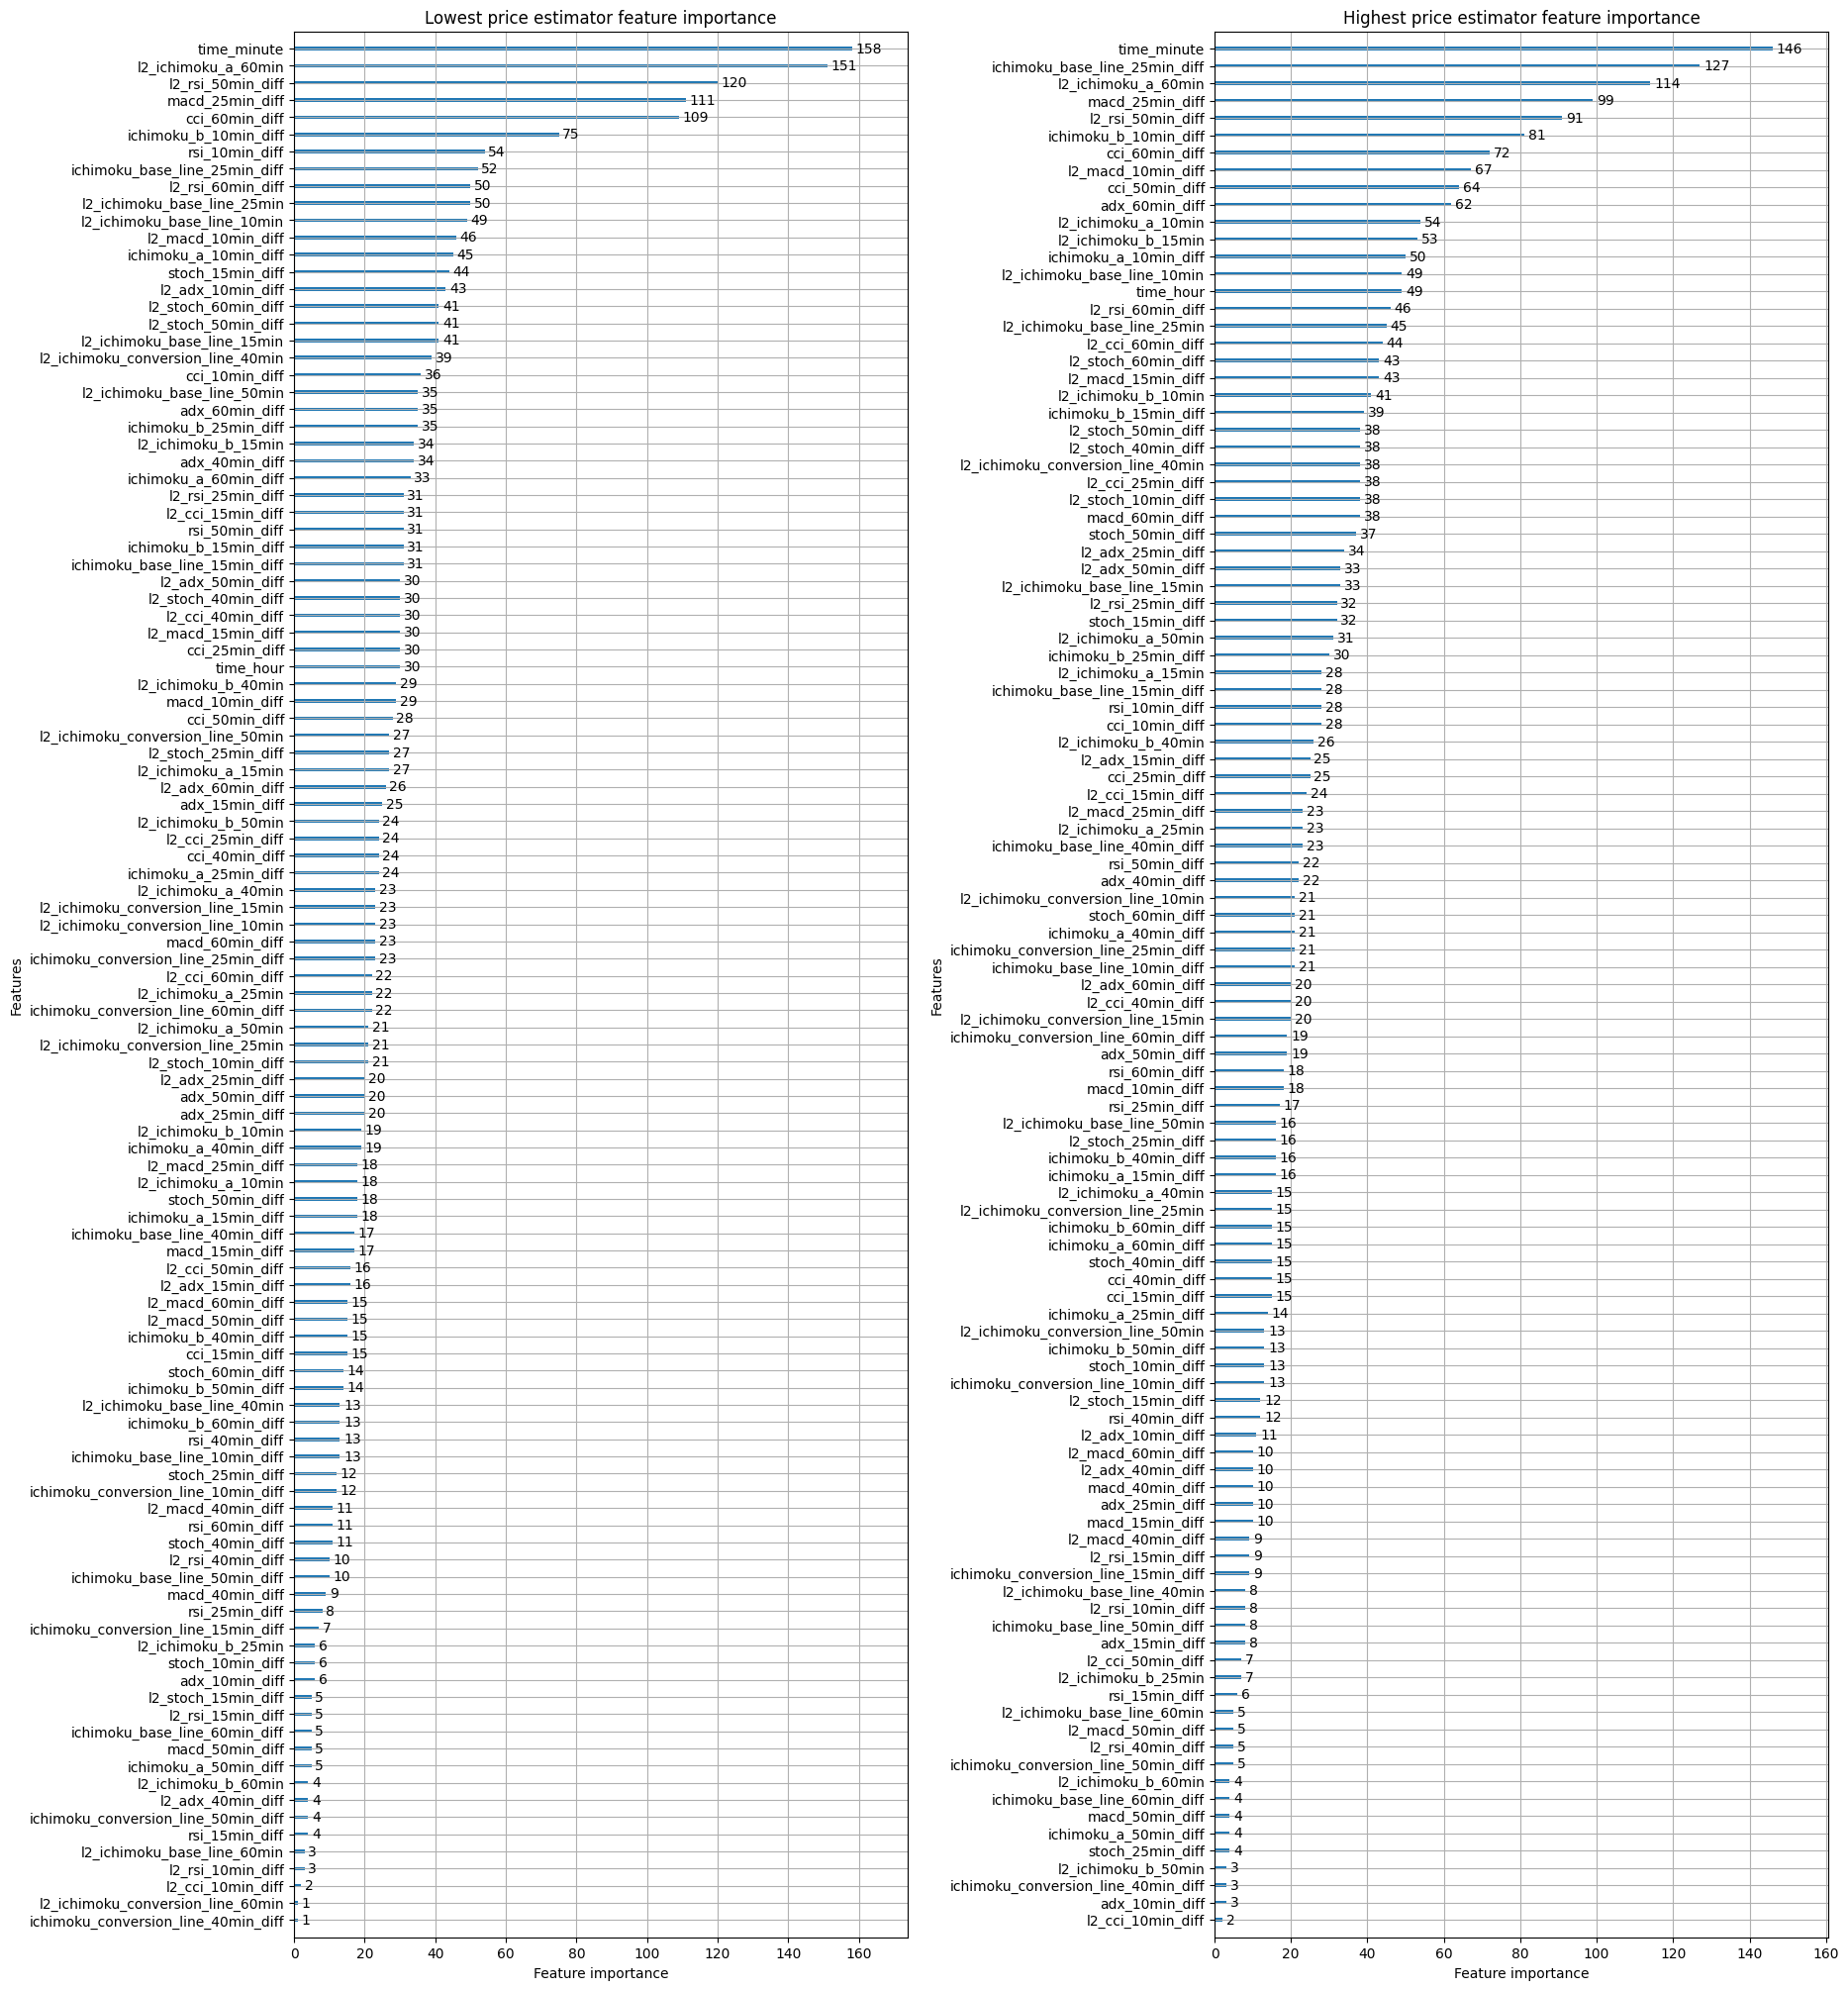

In [20]:
def plot_importance():
    fig, axes = plt.subplots(ncols=2, figsize=(20, 25))  # Specify width and height
    
    lgb.plot_importance(model.estimators_[0], ax = axes[0])
    lgb.plot_importance(model.estimators_[1], ax = axes[1])
    plt.subplots_adjust(wspace=0.5)
    axes[0].set_title('Lowest price estimator feature importance')
    axes[1].set_title('Highest price estimator feature importance')
    plt.show()
plot_importance()

## MLFlow experiment

In [21]:
y_test.info()
y_pred.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2025-05-03 07:00:00 to 2025-05-10 07:00:00
Freq: 15T
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   673 non-null    float64
 1   fut_high_diff  673 non-null    float64
dtypes: float64(2)
memory usage: 31.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 673 entries, 2025-05-03 07:00:00 to 2025-05-10 07:00:00
Freq: 15T
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fut_low_diff   673 non-null    float64
 1   fut_high_diff  673 non-null    float64
dtypes: float64(2)
memory usage: 31.9 KB


In [22]:
import mlflow
from mlflow import MlflowClient

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

#mlflow.set_tracking_uri('http://localhost:5000')
#mlflow_client = MlflowClient()

def new_experiment(mflow_client, experiment_name):
    print(f'Creating new mlflow experiment {experiment_name}')
    experiment_tags = {'project_name': 'pytrade2'}
    artifact_location='s3://pytrade2/mlartifacts'
    experiment = mlflow_client.create_experiment(
        name=experiment_name, tags=experiment_tags, artifact_location=artifact_location
    )    
    return experiment

def ensure_experiment(mlflow_client, experiment_name):
    experiments = mlflow_client.search_experiments(filter_string=f"name = '{experiment_name}' AND tags.project_name='pytrade2'")
    if not experiments:
        experiment = new_experiment(mlflow_client, experiment_name)
    else:
        experiment = experiments[-1]
    return experiment


In [23]:
def calc_metrics():
    """ Metrics to use for evaluation """
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    profit_mean = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].mean()
    profit_median = signal_ext.loc[signal_ext['signal'] != 0, 'profit'].median()
    profit_drawdown_ratio = sum(signal_ext['profit'])/max(signal_ext['drawdown'])

    return {
        'profit_drawdown_ratio': profit_drawdown_ratio,
        'profit_mean': profit_mean,
            'profit_median': profit_median,
            "mae": mae, 
            "mse": mse, 
            "rmse": rmse, 
            "r2": r2}

In [24]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

if do_log_experiment:
    print('Logging experiment')
    experiment = ensure_experiment(mlflow_client, experiment_name)
    mlflow.set_experiment(experiment_name)
    
    metrics = calc_metrics()
    #print(metrics)
    #run_name = f'{experiment_name}_{datetime.now()}'
    
    params = {
        # "n_estimators": 100,
        # "max_depth": 6,
        # "min_samples_split": 10,
        # "min_samples_leaf": 4,
        # "bootstrap": True,
        # "oob_score": False,
        # "random_state": 888,
    
        'train_size_rows': len(x_train),
        'history_days': history_days,
        'test_days': test_days,
        'profit_loss_ratio':  profit_loss_ratio,
        'take_profit_min_coeff': take_profit_min_coeff,
        'stop_loss_max_coeff': stop_loss_max_coeff,
        'stop_loss_add_ratio': stop_loss_add_ratio,
        'take_profit_max_coeff': take_profit_max_coeff,
        'stop_loss_min_coeff': stop_loss_min_coeff,
        'is_trailing_stop': is_trailing_stop,
        'comission_pct': comission_pct,
        'features_candles_periods': features_candles_periods,
        'target_period': target_period
    }
    
    
    # Initiate the MLflow run context
    import inspect
    print(inspect.signature(mlflow.sklearn.log_model))
    with mlflow.start_run(run_name = run_name) as run:
        #mlflow.set_tags({'tag': 'val'})
        # Log the parameters used for the model fit
        mlflow.log_params(params)
    
        # Log the error metrics that were calculated during validation
        mlflow.log_metrics(metrics)
    
        if do_log_model:
            # Log an instance of the trained model for later use
            artifact_path = run_name
            mlflow.sklearn.log_model(
                sk_model=model, 
                input_example=x_test,
                artifact_path=artifact_path,
                registered_model_name=model_name
            )

            # Set trade ready flag
            if is_trade_ready:
                # set extra tags on the model
                model_info = mlflow_client.get_latest_versions(model_name)[0]
                print(f'Setting model {model_name} v{model_info.version} is_trade_ready={is_trade_ready}')
                mlflow_client.set_model_version_tag(
                    name=model_name,
                    version=model_info.version,
                    key='is_trade_ready',
                    value=is_trade_ready
                )            
